In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import os
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dekiru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import data and clean data

In [4]:
dataset_path = "/home/dekiru/Desktop/email-spam-detector-system/data/raw/spam_ham_dataset.csv"

In [5]:
df = pd.read_csv(dataset_path)
df.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


In [12]:
# Check the duplicated values 
print(f"Duplicated values in a dataset: {df.duplicated().sum()}")

Duplicated values in a dataset: 0


## Lets check the label column

In [13]:
df["label"].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

## Data Visulization

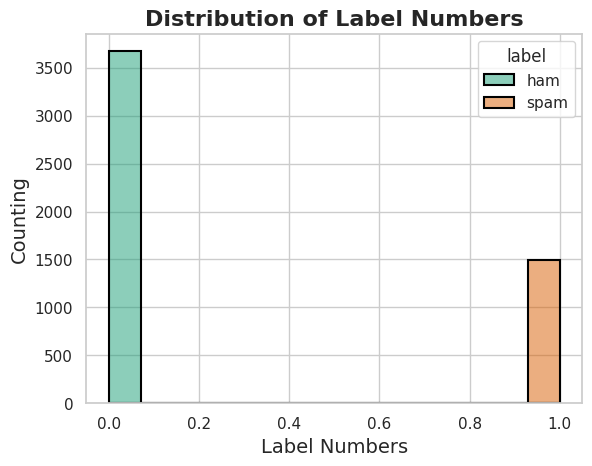

In [15]:
sns.set(style="whitegrid")

sns.histplot(data=df, x="label_num", hue = "label", palette="Dark2", edgecolor="black", linewidth=1.5)

plt.title("Distribution of Label Numbers", fontsize=16, fontweight='bold')
plt.xlabel("Label Numbers", fontsize=14)
plt.ylabel("Counting", fontsize=14)

plt.show()

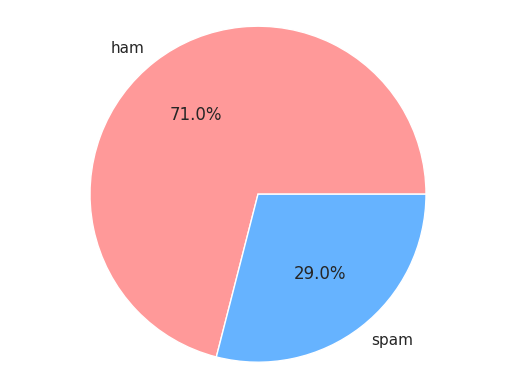

In [16]:
# lets check through pie chart
labels = df['label'].value_counts().index
sizes = df['label'].value_counts().values
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']  # Define custom colors

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Ensures the pie chart is a circle
plt.show()

In [17]:
df.replace({r'\r\n':' '}, regex=True, inplace=True)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291 thi...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001 ( see at...",0
2,3624,ham,"Subject: neon retreat ho ho ho , we ' re aroun...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs this deal is to b...,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [19]:
df.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [20]:
df.duplicated().sort_values(ascending=False)

0       False
3474    False
3452    False
3451    False
3450    False
        ...  
1722    False
1721    False
1720    False
1719    False
5170    False
Length: 5171, dtype: bool

In [21]:
# Tokenize
ps = PorterStemmer()
corpus = []

all_stop_words = set(stopwords.words('english'))
all_stop_words.remove('not')

for i in range(len(df)):
    text = df['text'][i].lower().translate(str.maketrans('','', string.punctuation)).split()
    text = [ps.stem(word) for word in text if word not in all_stop_words]
    text = ' '.join(text)
    corpus.append(text)

In [22]:
# corpus = np.asarray(corpus)
# output_path = '/home/dekiru/Desktop/email-spam-detector-system/data/postprocessing/spam.txt'
# np.savetxt(output_path, corpus, fmt='%s')  # fmt='%s' dùng để lưu dưới dạng chuỗi

In [23]:
mostCommon = Counter(corpus).most_common(20)
# mostCommon

# Creating BOW model

In [24]:
cv = CountVectorizer(max_features= 42500)
X = cv.fit_transform(corpus).toarray()
y = df['label_num']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [30]:
weights_dir = "/home/dekiru/Desktop/email-spam-detector-system/weights"

In [31]:
results = {}
for name, model in models.items():
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Đánh giá
    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)
    
    # Lưu kết quả
    results[name] = acc
    
    # Lưu weights của mô hình vào thư mục "weights"
    model_file = os.path.join(weights_dir, f"{name.replace(' ', '_').lower()}_model.pkl")
    with open(model_file, "wb") as f:
        pickle.dump(model, f)
    print(f"Model {name} đã được lưu vào file {model_file}")

# Hiển thị mô hình tốt nhất
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.2f}")

Model: Logistic Regression
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       742
           1       0.96      0.97      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035

--------------------------------------------------
Model Logistic Regression đã được lưu vào file /home/dekiru/Desktop/email-spam-detector-system/weights/logistic_regression_model.pkl
Model: Random Forest
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.96      0.95      0.96       293

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035

--------------------------------------

/home/dekiru/Desktop/env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [08:48:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       742
           1       0.95      0.98      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035

--------------------------------------------------
Model XGBoost đã được lưu vào file /home/dekiru/Desktop/email-spam-detector-system/weights/xgboost_model.pkl
Best Model: Logistic Regression with Accuracy: 0.98


In [33]:
print(results.values())

dict_values([0.9797101449275363, 0.9748792270531401, 0.9652173913043478, 0.8521739130434782, 0.9748792270531401, 0.9777777777777777])


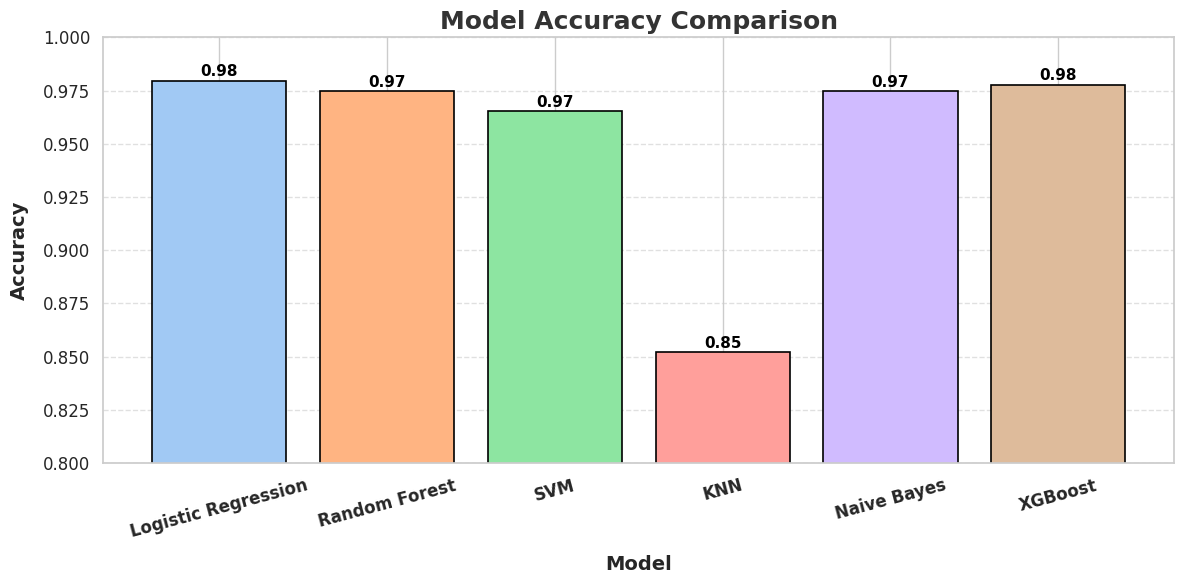

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tùy chọn phong cách
sns.set_theme(style="whitegrid")

# Dữ liệu
model_names = list(results.keys())
accuracies = list(results.values())

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
colors = sns.color_palette("pastel")[:len(model_names)]  # Bảng màu pastel đẹp mắt
bars = plt.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Hiển thị giá trị trên từng cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002,
             f"{bar.get_height():.2f}", ha='center', fontsize=11, color='black', fontweight='bold')

# Tùy chỉnh biểu đồ
plt.title("Model Accuracy Comparison", fontsize=18, fontweight='bold', color="#333333")
plt.xlabel("Model", fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14, labelpad=10, fontweight='bold')
plt.ylim(0.8, 1.0)  # Điều chỉnh trục y
plt.xticks(fontsize=12, rotation=15, fontweight='bold')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị
plt.show()


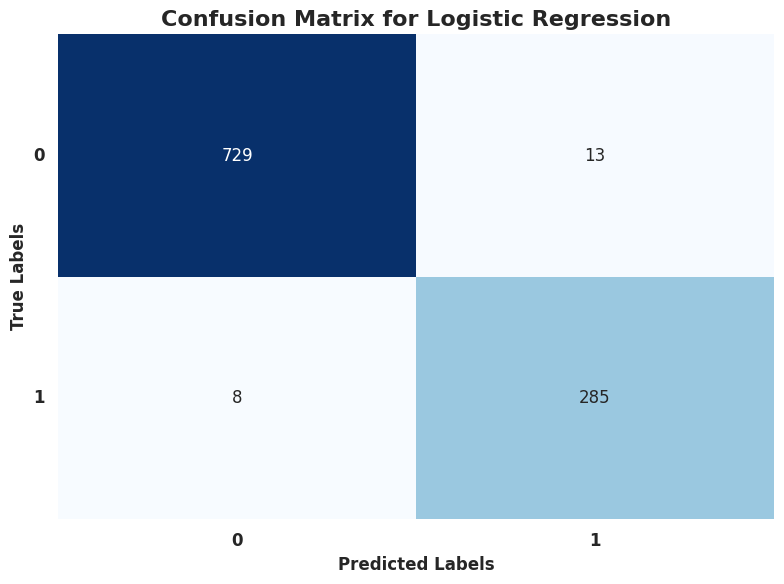

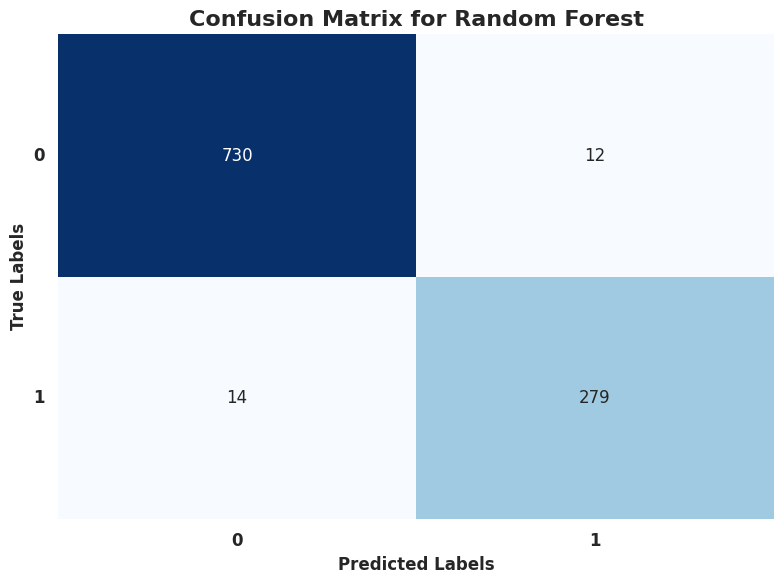

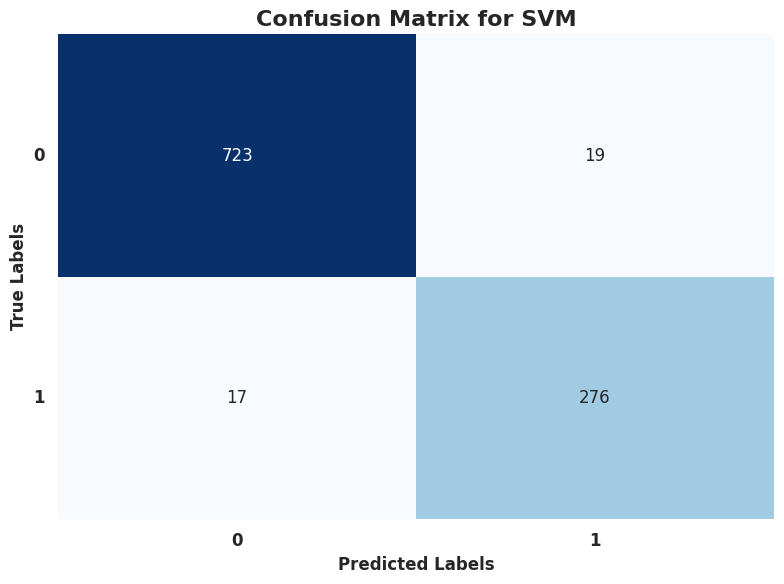

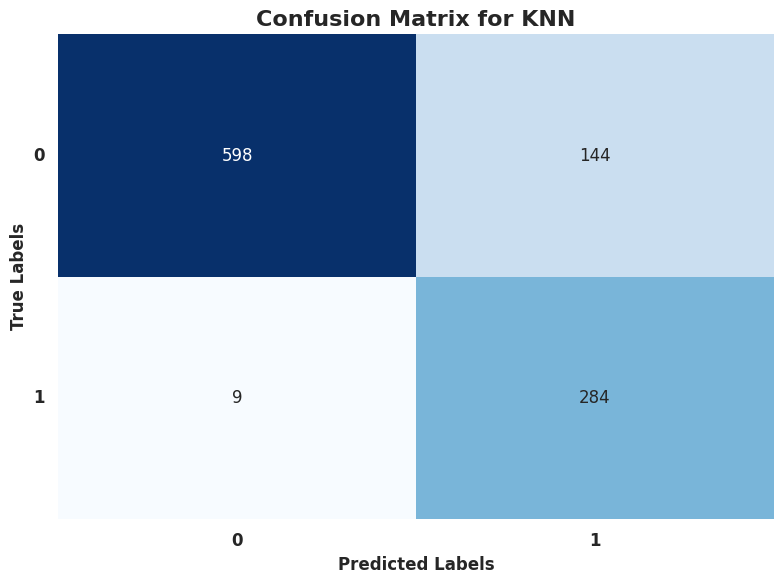

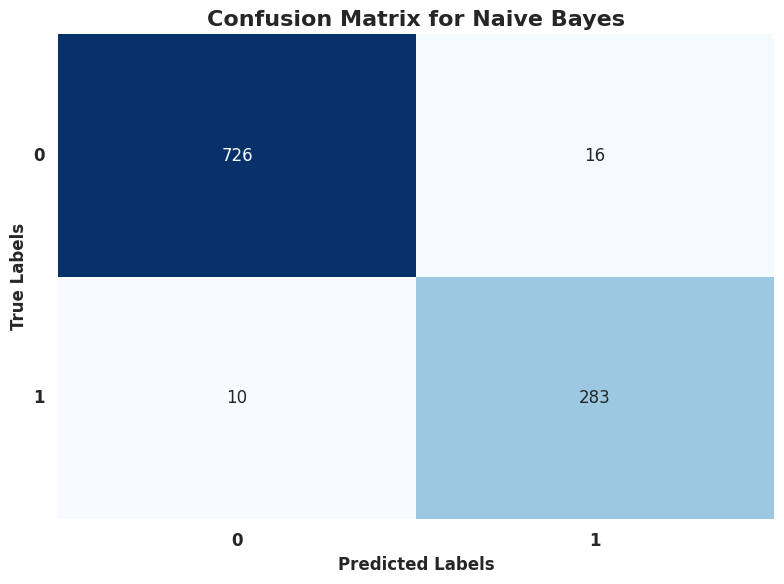

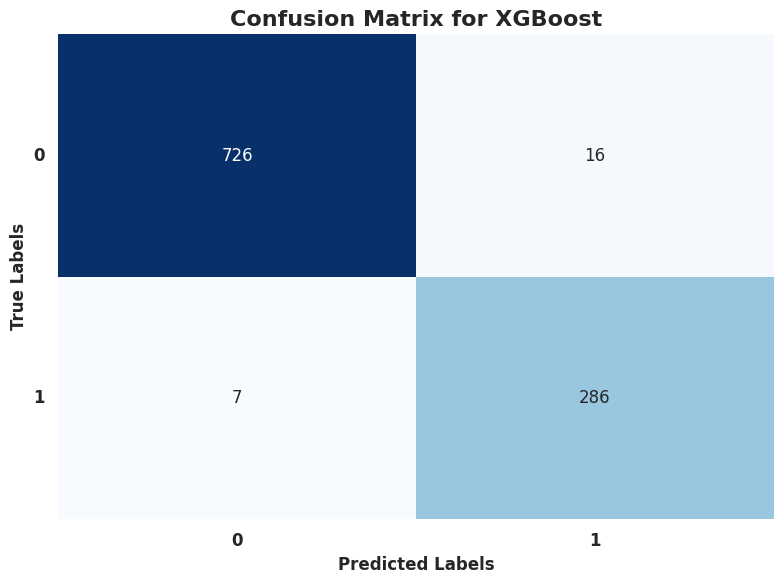

In [37]:
for model_name, model in models.items():
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Tạo ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    
    # Vẽ biểu đồ Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
    plt.ylabel("True Labels", fontsize=12, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold', rotation=0)
    plt.tight_layout()
    
    # Hiển thị biểu đồ
    plt.show()